In [47]:
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from PIL import Image    
from mpl_toolkits.mplot3d import Axes3D





# Starting Model to solve things in a more intuitive order

Battery Characteristics

In [48]:
### total charge in mAh (theoretical capacity and experimental capacity)
theoretical_capacity = 0.000675164504326091 #Ah
theoretical_capacity = 1000*theoretical_capacity #mAh 
experimental_capacity= 0.000716894394951807 #Ah
experimental_capacity = experimental_capacity*1000 #mAh

### i step for x
### j step for t
### k step for r

#Universal gas constantl
R = 8.3145 #J/molK

#Experimental temperature
T = 273.15 + 25 #K

### Faraday's constant
F = 96485.33289 # C/mol

#Number of electrons per electron transfer event
n = 2

# Transfer coefficient/symmetry coefficient
alpha = 0.5

### Number of physically discritized points 
N = 191  # number of points to discretize

### Total time of discharge
total_time = 41035.97 # seconds

t = np.linspace(0,total_time,N) # time array (s)
dt = total_time/(N - 1)


### Depth of discharge
### The fraction the battery has been discharge
y = t/total_time


### Setting up array of depth into the cathode material (x)
L = 1.0 # dimensionless length array
Le = 2.8e-5 * 100 # length/depth of separator (cm) (separator soaked in electrolyte, e = electrolyte)
Ls = 2e-5 *100 # length/depth of cathode (cm) (s = solid)
x = np.linspace(0, L, N) # position along the rod
dx = L / (N - 1)


### Setting up array of depth of diffusion into particles (r)
Diameter = 600 #Diameter of cathode particles (nm)
Diameter = Diameter/1e9 # Diameter of cathode particles (m)
Diameter = Diameter*100 #Diameter of cathode particles (cm)
Rs = Diameter/2 #Radius of cathode particles (cm)
r = np.linspace(0, Rs, N)
dr = L / (N - 1)


### area of electrode
### CR2032 model battery casing is 20mm in diameter
re = 10 #radius of electrode(mm)
re = re/10 # radius of electrode (cm)
Ae = np.pi*re*re #cm^2

# applied current 
Iapp = 6.29282063e-05 # Amps
Iapp = Iapp*1000 # mA


# current density 
iapp = Iapp/Ae #mA/cm^2


#Spesific surface area
av = 2.31e6 # m^2/m^3
av = av/100 #1/cm

Equation to model the change in the exchange current density due to the change in fundamental insertion reaction.
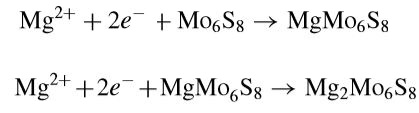

Kim et al. proposes tanh(x) funtions to model the change in the kinetics for the two sequential reactions. They are reproduced as accurately as possible here.

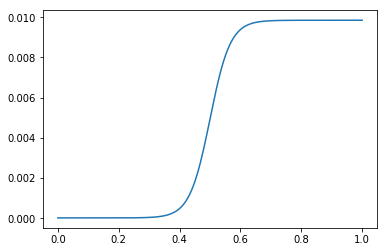

In [49]:
### both the kinetics and diffusivity in the solid differed greatly in the two reactions. 

def func_io(j):
    i_ofast = (0.009838027698240602 + 0.009849498195788928 + 0.009856505279562468)/3 
    i_oslow= (0.000017945811609164856 + 0.000018038360660111245 + 0.000017995624361842263)/3
    S_i = 15
    b = (i_ofast + i_oslow)/2
    b_ = (i_ofast - i_oslow)/2
    
    ### Total time of discharge
    total_time = 41035.97 # seconds
    t = np.linspace(0,total_time,N) # time array (s)
    y = t/total_time
    
    i_opos = b_*np.tanh(S_i*(y[j]-0.5)) + b 
    return i_opos

io = np.zeros(N)
for j in range(N):
    io[j]=func_io(j)

plt.plot(y,io)

Defining function to calculate i_n as a function of depth into the cathode (x) and time (t) calclated at constant concentration
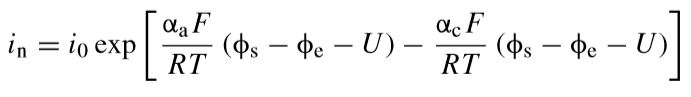
Disregarding overpotential (U)

# Steady state current distribution with built in Boudary Value Problem Solver

Current distribution of ionic conductivity (flow charge carrying ions through the elctrolyte) and solid state conductivity (flow of electrons through chevrel particles).

Text(0,0.5,'i')

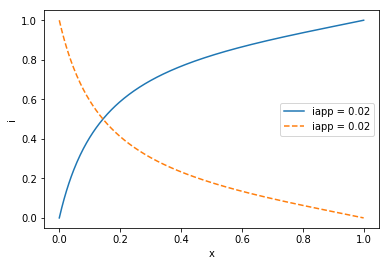

In [50]:
#electrolyte conductivity 
kappa = 0.06 #S/cm
#electrode conductivity
sigma = 300/100 #S/cm




beta = (1-alpha)*n*F/R/T

def f(x,y):
    #unpack the vector into its 4 variables
    phi2,phi1,i1,i2=y
    
    #specify the 4 differential equations
    dphi1_dx = -i1/sigma
    dphi2_dx = -i2/kappa
    
    di1_dx = av*i_o*np.exp(beta*(phi1-phi2))
    di2_dx = -av*i_o*np.exp(beta*(phi1-phi2))
    
    df_dx = np.array([dphi1_dx,dphi2_dx,di1_dx,di2_dx])  
    
    return df_dx


def bounds(y0,yf):

    phi10,phi20,i10,i20 = y0
    phi1f,phi2f,i1f,i2f = yf

    phi1_bc = i10 - 0
    phi2_bc = phi2f - 0
    i1_bc = i1f - iapp
    i2_bc = i20 - iapp

    y = np.array((phi1_bc,phi2_bc,i1_bc,i2_bc))
    return y


f_i=np.zeros((4,N))


i_o = (0.000017945811609164856 + 0.000018038360660111245 + 0.000017995624361842263)/3 #mA/cm^2
i_o
sol=solve_bvp(f,bounds,x,f_i)
inoms = sol.y[2][::2] #nomical current through solid cathode
inome = sol.y[3][::2] #nomical current through electrolyte
plt.figure(0)
plt.plot(sol.x/L,sol.y[2]/iapp,label='iapp = %.2f' %(iapp))
plt.plot(sol.x/L,sol.y[3]/iapp,'--',label='iapp = %.2f' %(iapp))


plt.legend()    
plt.xlabel('x')
plt.ylabel('i')


Function, that given a position argument and time arguemnts returns the nominal current

In [51]:
def func_in(i,j):
    current_x = inoms[i]/iapp
    current_t = io[j]
    i_nominal = current_x*current_t
    return i_nominal
print('hello')

hello


Creating 2D array of nomical current

In [52]:
i_nom = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        i_nom[i,j] = func_in(i,j)

Find smallest value in 2D matrix of nomical current (i_nom). This is so that values of zero can be replaced with it when taking log base 10.

In [53]:
smallest = 10
for i in range(N):
    for j in range(N):
        if np.isfinite(i_nom[i,j]) == False:
            continue
        else:
            if i_nom[i,j] != 0:
                if smallest >i_nom[i,j]:
                    smallest = i_nom[i,j]

print("Smallest value is {:} so smallest (non -inf) log base 10 value is {:.3f} ".format(smallest, np.log10(smallest)))


Smallest value is 6.12164308008978e-07 so smallest (non -inf) log base 10 value is -6.213 


Taking log base ten of the 2D array

In [54]:
log_i_nom = np.zeros((N,N))
log_i_nom_2 = log_i_nom.copy()
for i in range(N):
    for j in range(N):
        if i_nom[i,j] ==0:
            log_i_nom[i,j] = np.log10(smallest)
        else: 
            log_i_nom[i,j] = np.log10(i_nom[i,j])

In [55]:
for i in range(N):
    for j in range(N):
        if i_nom[i,j] ==0:
            log_i_nom[i,j]=np.log10(smallest)

Text(0.5,0.92,'Nominal Current as Function of Position and Time')

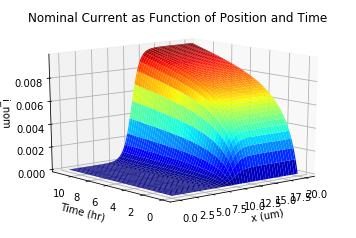

In [56]:
fig = plt.figure()
ax0 = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
ax0.plot_surface(SX*Ls*10000, ST/3600, i_nom, cmap='jet')
ax0.set_xlabel('x (um)')
ax0.set_ylabel('Time (hr)')
ax0.set_zlabel('i_nom',rotation = 45)
ax0.view_init(elev=15, azim=-130) # adjust view so it is easy to see
ax0.set_title('Nominal Current as Function of Position and Time')

Text(0.5,0.92,'Log Base 10 Nominal Current as Function of Position and Time')

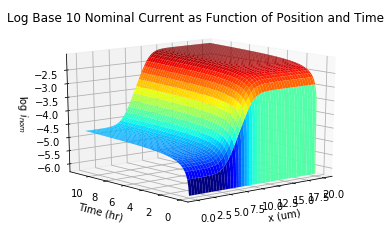

In [65]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot_surface(SX*Ls*10000, ST/3600, log_i_nom, cmap='jet')
ax1.set_xlabel('x (um)')
ax1.set_ylabel('Time (hr)')
ax1.set_zlabel('log $i_{nom}$',rotation = 45)
ax1.view_init(elev=15, azim=-130) # adjust view so it is easy to see
ax1.set_title('Log Base 10 Nominal Current as Function of Position and Time')

In [58]:
xt = np.zeros(N)
temp= np.zeros(N)
for i in range(1,N):
    xt[i] = dx+xt[i-1]



In [59]:
De = 5e-12 # Diffusivity of electrolyte (m^2/s)
De = De * 1000 # Diffusivity of electrolyte (cm^2/s)
εe = 0.724 # Porosity of separator,  ε of seporator is ε of electrolyte???  (#)
t_plus = 0.018 # Transition number (#)
av= 9.63e5 # specific (1/m) 
av = av/100
iot = 2.003810704121193e-13 #A/m^2

In [60]:
def my_odeint(function,y0,x):
    y = np.zeros((np.size(x),np.size(y0)))
    y[0,:] = y0 
    for i in range(len(x)-1):
#        dx = x[i+1]-x[i]
        y[i+1,:]=y[i,:] + np.asarray(function(y[i,:],x[i]))*dx
    return y
        

In [61]:
### Temperary diffusion (cm^2/g)
Ds = 2.005445683949527e-13 

In [62]:
def funCs(Cs, t):
    dCs_dt = np.zeros(r.shape)

    # boundary condition at t = 0
    dCs_dt[0] = 0 # constant at initial boundary condition
    dCs_dt[-1] = 0 # constant at final boundary condition    
    # now for the internal nodes
    for i in range(1, N-1):        
     #   dCs_dt[i] = 1e7*Ds * (Cs[i + 1] - 2*Cs[i] + Cs[i - 1])/dr/dr + 2*Ds*(Cs[i+1] + Cs[i])/r[i]/dr
        dCs_dt[i] = 1e7*Ds*(Cs[i + 1] - 2*Cs[i] + Cs[i - 1])/dr/dr + 2*Ds*(Cs[i+1] + Cs[i])/r[i]/dr

    return dCs_dt



In [63]:
### initial concentration of Mg ions in the chevrel particles (cathode material) is 0
Cso = np.zeros(r.shape)

### Initial conditions at r = initial and r = final 
Cso[0]=0
Cso[-1]=1
Cs = my_odeint(funCs, Cso, t)
Cs = Cs.T


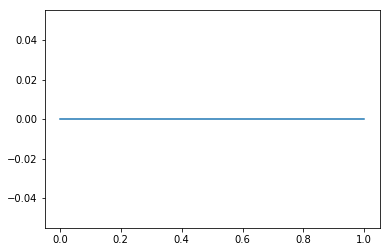

In [64]:
plt.plot(r/Rs,Cs[50])

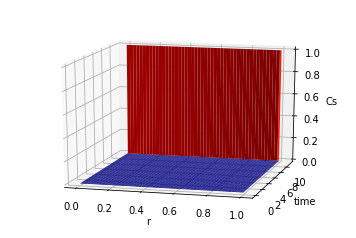

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
SX, ST = np.meshgrid(r, t)
ax.plot_surface(SX/Rs, ST/3600, Cs, cmap='jet')
ax.set_xlabel('r')
ax.set_ylabel('time')
ax.set_zlabel('Cs')
ax.view_init(elev=15, azim=-75) # adjust view so it is easy to see

# Solving Charge Balance in Electrolyte

$$\frac{\partial }{\partial t} \bigg( -k_{eff} \frac{\partial \phi_e}{\partial x}\bigg) + \frac{2k_{eff}RT(1-t_+^0)}{F}\bigg(1+ \frac{\partial ln f_{+-}}{\partial ln c_e} \bigg) \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) = a_v i_n$$


$$\frac{\partial }{\partial t} \bigg( -k_{eff} \frac{\partial \phi_e}{\partial x} \bigg) +
\frac{2k_{eff}RT(1-t_+^0)}{F} \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) +  \frac{2k_{eff}RT(1-t_+^0)}{F}\frac{\partial ln f_{+-}}{\partial ln c_e} \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) = a_v i_n$$


$$
\frac{\partial }{\partial t} \bigg( -k_{eff} \frac{\partial \phi_e}{\partial x} \bigg) + \frac{2k_{eff}RT(1-t_+^0)}{F} \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) + \leq \frac{2k_{eff}RT(1-t_+^0)}{F} \frac{1}{f_{+-}} \frac{\partial f_{+-}}{\partial ln c_e} \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) = a_v i_n
$$

$$
if\quad \Delta f_{+-} = 0
$$

$$
\frac{\partial }{\partial t} \bigg( -k_{eff} \frac{\partial \phi_e}{\partial x} \bigg) + \frac{2k_{eff}RT(1-t_+^0)}{F} \frac{\partial}{\partial x} \bigg( \frac{\partial ln c_e}{\partial x} \bigg) + = a_v i_n
$$